# Circuit of Hamiltonina Simulation using TheQ

This notebook will teach you how to construct your own circuits for the Hamiltonina Simulation using TheQ.

# Importing Packages

In [ ]:
import matplotlib as mpl # Required to display some fancy circuits
from scipy.linalg import expm
import numpy as np
# Server addresses should be stable, but may occasionally be offline
import requests
import json
import math
import matplotlib.pyplot as plt # For plotting functions
from google.colab import files

#req_str = 'http://8b851bd5c0ec.ngrok.io/qsim/perform_operation'
req_str = 'http://8fc11588c850.ngrok.io/qsim/perform_operation'
#req_str_qasm = 'http://8b851bd5c0ec.ngrok.io/qsim/qasm'
req_str_qasm = 'http://8fc11588c850.ngrok.io/qsim/qasm'

In [ ]:
# We need these for verifying our circuits later
Z_gate = np.matrix([[1, 0], [0, -1]])
X_gate = np.matrix([[0, 1], [1, 0]])
Y_gate = np.matrix([[0, -1j], [1j, 0]])

# Required functions

These are some required functions to run any circuit in TheQ.

In [ ]:
# Define Create ciruit (these are the four core definitions for any circuit)
# all circuits must be bookmarked by the create_circuit and destroy_circuit command

# Initial_state is a binary integer to initalise all qubit, 
# most often initial_state=0.
def create_circuit(qubits,initial_state):
    data = {
        'operation': 'create_circuit',
        'num_qubits': qubits
    }
    result = requests.post(req_str, json=data)
    json_obj = json.loads(result.content)
    reg_id = json_obj['result']

    data = {
        'operation': 'set_state',
        'register': reg_id,
        'state': initial_state,
        'complex_value': {'re': 1, 'im': 0}
    }
    result = requests.post(req_str, json=data)
    return reg_id

# Gates.  gate_name and params are specified from the list above
def gate(register_id, gate_name, params):
    data = {
        'operation': 'gate',
        'register': register_id,
        'gate': gate_name
    }
    for k in params.keys():
        data[k] = params[k]
    result = requests.post(req_str, json=data)
    json_obj=json.loads(result.content)
    return json_obj['result']

# params contain an array of qubit numbers to measure, 'lq2m': [0,1,3] would measure qubits 0, 1 and 3 and return the 
# corresponding 3-bit integer value from 0 to 7.
def measure_qubit(register_id, params):
    data = {
        'operation': 'measure', 
        'register': register_id,
    }
    for k in params.keys():
        data[k] = params[k]
    result = requests.post(req_str, json=data)

    json_obj = json.loads(result.content)
    return json_obj['result']

# Always call destroy_circuit to terminate simulation (turn off your QC)
def destroy_circuit(register_id):
  data = {
        'operation': 'destroy_circuit', 
        'register': register_id
  }
  result = requests.post(req_str, json=data)

# Print allows you to output the current computational state of the machine.
def print_vector(register_id):
  data = {
        'operation': 'state_vector', 
        'register': register_id
  }
  result = requests.post(req_str, json=data)
  json_obj = json.loads(result.content)
  return json_obj['result']


# The problem

Now we move on to the main section. In this notebook, we will explain the construction and implementation of basic Hamiltonian simulation circuits. The problem can be defined as follow: For a Hamiltonian $H$ acting on $n$ qubits, can we implement the operator (gate) $e ^ {-iHt}$, for any $t \geq 0 $? Throughout this notebook, we will be dealing with simple Hamiltonians acting on $3$ qubits.

# Product Forms

We start with Hamiltonians that have a product form, by which, we mean Hamiltonians $H = A \otimes B \otimes C$, where $A, B, C \in \{ I, X, Y, Z\}$.  

## Example 1

Our first example is $H = Z \otimes Z \otimes Z$. The circuit implementing $e ^ {iHt}$ in this case is given as

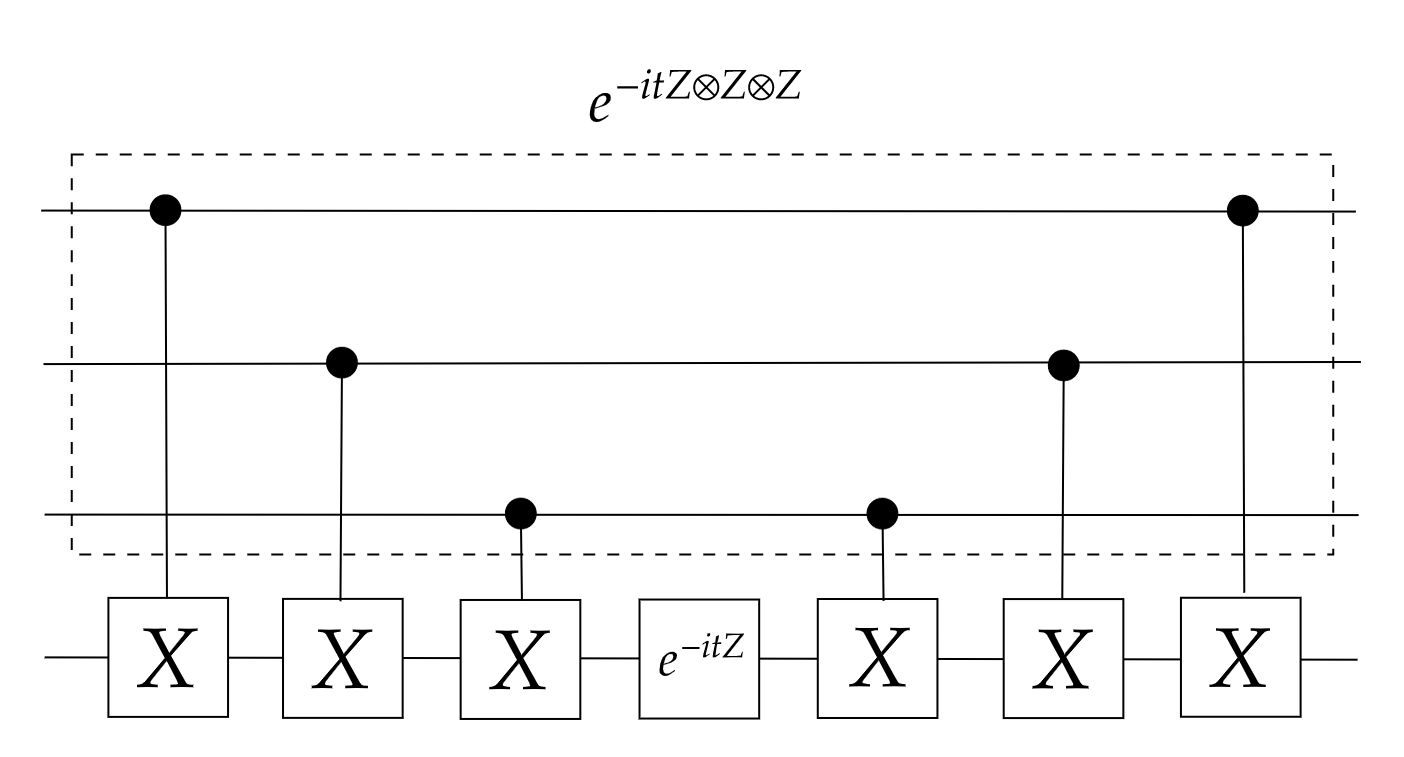

The $e ^ {-iZt}$ gate can be implemented by the gate $R_Z(2t)$. In this example, let $t = 1$.

Now we move on to the construction of this circuit. Before that, assign $t = 1$.

In [ ]:
t = 1

Since the circuit contains four qubits, we create a circuit with four qubits.

In [ ]:
# Prepare the circuit
reg_id = create_circuit(4,0)

Now, we shall start applying the gates. We start with the first $3$ CNOT gates. 

In [ ]:
# Apply the first 3 CNOT gates
gate(reg_id, 'cnot', {'q_control': 0, 'q_target': 3})
gate(reg_id, 'cnot', {'q_control': 1, 'q_target': 3})
gate(reg_id, 'cnot', {'q_control': 2, 'q_target': 3})


True

Then, we apply the rotation around Z axis.

In [ ]:
# Apply Rz gate. We give the parameter as -2t because in TheQ, to rotate around any axis by t, we have to give R(-t).
gate(reg_id, 'zrot', {'q': 3, 'theta': -2 * t})

True


Now, we apply the next $3$ CNOT gates.

In [ ]:
# Apply the next 3 CNOT gates
gate(reg_id, 'cnot', {'q_control': 2, 'q_target': 3})
gate(reg_id, 'cnot', {'q_control': 1, 'q_target': 3})
gate(reg_id, 'cnot', {'q_control': 0, 'q_target': 3})


True

Now that we have successfully constructed the circuit, let's move on to verify whether the circuit we have built is actually $e ^ {-iZ \otimes Z \otimes Z}$. For that, first we need the actual matrix $e ^ {-iZ \otimes Z \otimes Z}$.

In [ ]:
actual_matrix = expm(-1j * (np.kron(np.kron(Z_gate, Z_gate), Z_gate)))

Ok. Now, we shall execute our quantum circuit on each of the $8$ basis states to get the column of the operator, and in each case, compare the norm of the difference between that and the actual columns of "actual_matrix". That is, let $G$ be the unitary made by the circuit. For every $i \in \{ 0,1, \dots, 7\}$, we shall compute 

\begin{equation}
  \Big| \Big| G|i\rangle - \text{actual_matrix}[:,i]\Big| \Big|_2^2
\end{equation}

If all of these values are $0$, then we have succesfully implemented $e ^ {-iZ \otimes Z \otimes Z}$.

Before we move on to that, we destroy the circuit built earlier.

In [ ]:
# Destroy circuit
destroy_circuit(reg_id)

In [ ]:

# This function converts a decimal number to its binary expansion
def Binary(x, BitNo):
  format(x, 'b').zfill(BitNo)
  Binlist = [int(y) for y in list(format(x, 'b').zfill(BitNo))]
  return Binlist

for i in range(8):

  # Convert i from decimal to binary 
  bina = Binary(i,3)
  bina.reverse()
  
  # Prepare the circuit
  reg_id = create_circuit(4,0)

  # Prepare i
  for j in range(3):
    if bina[j] == 1:
      gate(reg_id, 'X', {'q': j})


  # Apply circuit
  gate(reg_id, 'cnot', {'q_control': 0, 'q_target': 3})
  gate(reg_id, 'cnot', {'q_control': 1, 'q_target': 3})
  gate(reg_id, 'cnot', {'q_control': 2, 'q_target': 3})
  
  gate(reg_id, 'zrot', {'q': 3, 'theta': -2 * t})

  gate(reg_id, 'cnot', {'q_control': 2, 'q_target': 3})
  gate(reg_id, 'cnot', {'q_control': 1, 'q_target': 3})
  gate(reg_id, 'cnot', {'q_control': 0, 'q_target': 3})

  # Simulate the circuit and compute the statevector
  statevector = np.zeros(16) + (1j * np.zeros(16))
  output = print_vector(reg_id)

  for j in range(len(output)):
    statevector[output[j]['state']] = output[j]['complex_value']['re'] + (1j * output[j]['complex_value']['im'])
  
  # Destroy circuit
  destroy_circuit(reg_id)

  # Disply the norm. 
  # The first 8 entries of the statevector is the vector of interest to us.
  print(np.linalg.norm(statevector[:8] - actual_matrix[:,i]) ** 2)


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


Since all outputs are $0$, we can safely say that the circuit we have prepared is actually $e ^ {-iZ \otimes Z \otimes Z}$.

## Example 2

Our second example is $H = Z \otimes X \otimes Y$. The circuit implementing $e ^ {iHt}$ in this case is given as

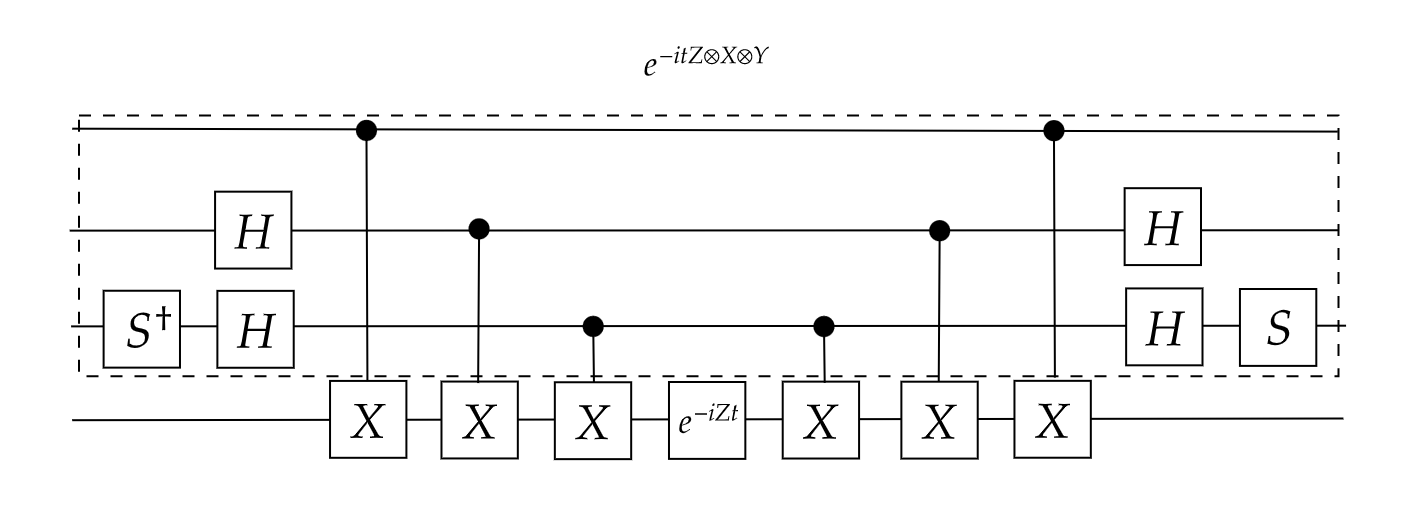

In this case, let $t = 0.5$. Since we have already explained the construction and verification of the previous Hamiltonian in detial, we shall directly go into the verification here, since the differences are minor.

In [ ]:
# Assign t = 0.5
t = 0.5

# Since Z is acting on qubit 1, the actual_matix in this case will have the form
actual_matrix = expm(-1j * 0.5 * (np.kron(np.kron(Y_gate, X_gate), Z_gate)))

for i in range(8):
  # Convert i from decimal to binary 
  bina = Binary(i,3)
  bina.reverse()
  
  # Prepare the circuit
  reg_id = create_circuit(4,0)

  # Prepare i
  for j in range(3):
    if bina[j] == 1:
      gate(reg_id, 'X', {'q': j})

  # Apply circuit
  gate(reg_id, 'zrot', {'q': 2, 'theta': np.pi/2})
  gate(reg_id, 'hadamard', {'q': 1})
  gate(reg_id, 'hadamard', {'q': 2})

  gate(reg_id, 'cnot', {'q_control': 0, 'q_target': 3})
  gate(reg_id, 'cnot', {'q_control': 1, 'q_target': 3})
  gate(reg_id, 'cnot', {'q_control': 2, 'q_target': 3})
  
  gate(reg_id, 'zrot', {'q': 3, 'theta': -2 * t})

  gate(reg_id, 'cnot', {'q_control': 2, 'q_target': 3})
  gate(reg_id, 'cnot', {'q_control': 1, 'q_target': 3})
  gate(reg_id, 'cnot', {'q_control': 0, 'q_target': 3})

  gate(reg_id, 'hadamard', {'q': 1})
  gate(reg_id, 'hadamard', {'q': 2})
  gate(reg_id, 'zrot', {'q': 2, 'theta': -np.pi/2})

  # Simulate the circuit and compute the statevector
  statevector = np.zeros(16) + (1j * np.zeros(16))
  output = print_vector(reg_id)

  for j in range(len(output)):
    statevector[output[j]['state']] = output[j]['complex_value']['re'] + (1j * output[j]['complex_value']['im'])
  
  # Destroy circuit
  destroy_circuit(reg_id)

  # Disply the norm. 
  # The first 8 entries of the statevector is the vector of interest to us.
  print(np.linalg.norm(statevector[:8] - actual_matrix[:,i]) ** 2)


1.0477058897466563e-31
1.0477058897466563e-31
1.0477058897466563e-31
1.0477058897466563e-31
1.6640034719505718e-31
1.6640034719505718e-31
1.6640034719505718e-31
1.6640034719505718e-31


Here also, since all outputs are $0$, we can safely say that the circuit we have prepared is actually $e ^ {-iZ \otimes X \otimes Y}$.

# Sum of product Hamiltonians

In this section, we shall try simulating a Hamiltonian which can be written as the sum of $2$ product Hamiltonians.

## Sum of commuting product Hamiltonians

First we shall try a Hamiltonian which can be written as a sum of two commuting product Hamiltonians. We have already simulated Hamiltonians $H_1 = Z \otimes Z \otimes Z$ and $H_2 = Z \otimes X \otimes Y$. Since these two matrices commute, let's try simulating the Hamiltonian $H = H_1 + H_2$ as $e ^ {-iH_2t} e ^ {-iH_1t} $. Let's take $t = 2$. Note that, in this case, we just have to apply both circuits one after the other.

In [ ]:
# Assign t = 2
t = 2

# Actual matrix is given as
actual_matrix = expm(-1j * t * (np.kron(np.kron(Y_gate, X_gate), Z_gate) + np.kron(np.kron(Z_gate, Z_gate), Z_gate)))

for i in range(8):

  # Convert i from decimal to binary 
  bina = Binary(i,3)
  bina.reverse()
  
  # Prepare the circuit
  reg_id = create_circuit(4,0)

  # Prepare i
  for j in range(3):
    if bina[j] == 1:
      gate(reg_id, 'X', {'q': j})

  # Apply H1
  gate(reg_id, 'cnot', {'q_control': 0, 'q_target': 3})
  gate(reg_id, 'cnot', {'q_control': 1, 'q_target': 3})
  gate(reg_id, 'cnot', {'q_control': 2, 'q_target': 3})
  
  gate(reg_id, 'zrot', {'q': 3, 'theta': -2 * t})

  gate(reg_id, 'cnot', {'q_control': 2, 'q_target': 3})
  gate(reg_id, 'cnot', {'q_control': 1, 'q_target': 3})
  gate(reg_id, 'cnot', {'q_control': 0, 'q_target': 3})

  # Apply H2
  gate(reg_id, 'zrot', {'q': 2, 'theta': np.pi/2})
  gate(reg_id, 'hadamard', {'q': 1})
  gate(reg_id, 'hadamard', {'q': 2})

  gate(reg_id, 'cnot', {'q_control': 0, 'q_target': 3})
  gate(reg_id, 'cnot', {'q_control': 1, 'q_target': 3})
  gate(reg_id, 'cnot', {'q_control': 2, 'q_target': 3})
  
  gate(reg_id, 'zrot', {'q': 3, 'theta': -2 * t})

  gate(reg_id, 'cnot', {'q_control': 2, 'q_target': 3})
  gate(reg_id, 'cnot', {'q_control': 1, 'q_target': 3})
  gate(reg_id, 'cnot', {'q_control': 0, 'q_target': 3})

  gate(reg_id, 'hadamard', {'q': 1})
  gate(reg_id, 'hadamard', {'q': 2})
  gate(reg_id, 'zrot', {'q': 2, 'theta': -np.pi/2})

  # Simulate the circuit and compute the statevector
  statevector = np.zeros(16) + (1j * np.zeros(16))
  output = print_vector(reg_id)

  for j in range(len(output)):
    statevector[output[j]['state']] = output[j]['complex_value']['re'] + (1j * output[j]['complex_value']['im'])
  
  # Destroy circuit
  destroy_circuit(reg_id)

  # Disply the norm. 
  # The first 8 entries of the statevector is the vector of interest to us.
  print(np.linalg.norm(statevector[:8] - actual_matrix[:,i]) ** 2)


1.0245947304140097e-31
1.1401505270772434e-31
1.1401505270772434e-31
1.0245947304140097e-31
6.77927340424307e-32
7.472608184222474e-32
7.472608184222474e-32
6.77927340424307e-32


As expected, we are able to perfectly simulate the unitary $e ^ {-iHt}$.

## Sum of non-commuting product Hamiltonians

Now let's move on to a case where we have a Hamiltonian written as a sum of two non-commuting Hamiltonians. Let $H = H_1 + H_2$, where $H_1 = X \otimes Z \otimes Z$ and $H_2 = Z \otimes X \otimes Y$. One can see that $H_1$ and $H_2$ are actually non-commuting matrices. Let $t$ be 1. Here, $H_1$ can implemented as 

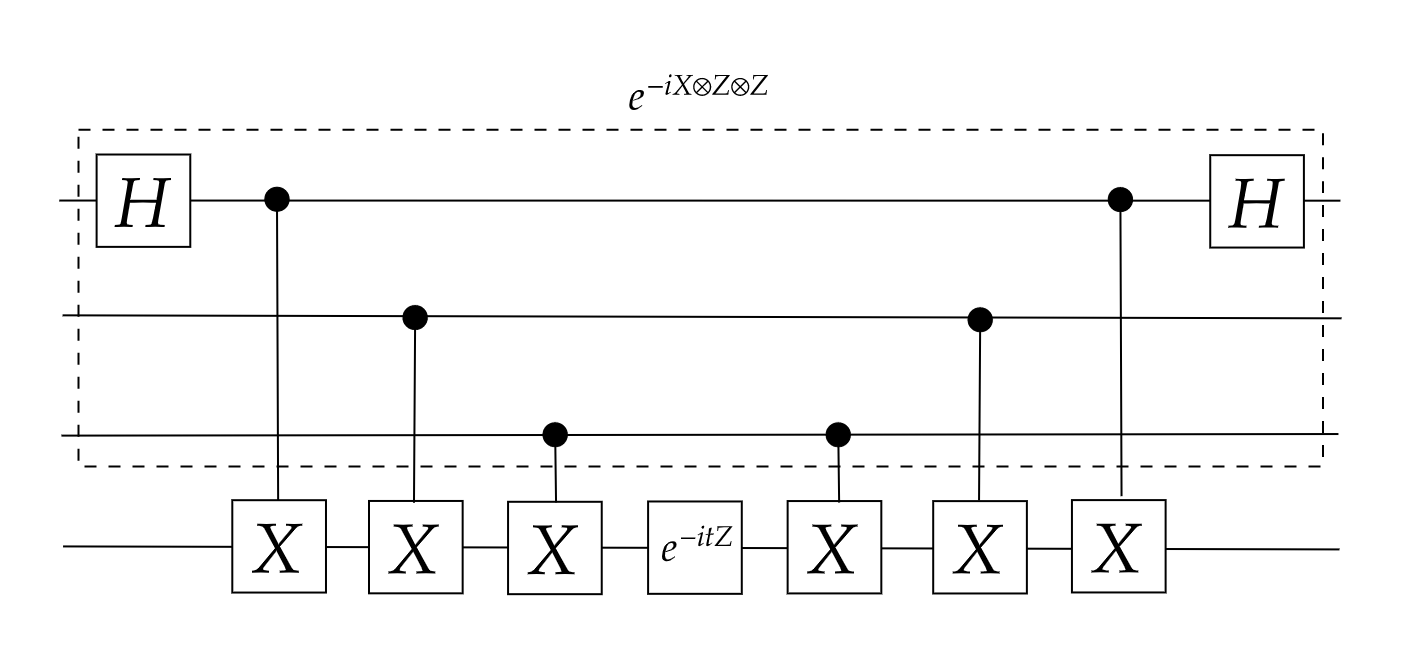


First, let's try the method we tried in the case of commuting matrices, that is, by simulating them one after the other.

In [ ]:
# Assign t = 2
t = 1

# Actual matrix is given as
actual_matrix = expm(-1j * t * (np.kron(np.kron(Y_gate, X_gate), Z_gate) + np.kron(np.kron(Z_gate, Z_gate), X_gate)))

for i in range(8):

  # Convert i from decimal to binary 
  bina = Binary(i,3)
  bina.reverse()
  
  # Prepare the circuit
  reg_id = create_circuit(4,0)

  # Prepare i
  for j in range(3):
    if bina[j] == 1:
      gate(reg_id, 'X', {'q': j})

  # Apply H1
  gate(reg_id, 'hadamard', {'q': 0})

  gate(reg_id, 'cnot', {'q_control': 0, 'q_target': 3})
  gate(reg_id, 'cnot', {'q_control': 1, 'q_target': 3})
  gate(reg_id, 'cnot', {'q_control': 2, 'q_target': 3})
  
  gate(reg_id, 'zrot', {'q': 3, 'theta': -2 * t})

  gate(reg_id, 'cnot', {'q_control': 2, 'q_target': 3})
  gate(reg_id, 'cnot', {'q_control': 1, 'q_target': 3})
  gate(reg_id, 'cnot', {'q_control': 0, 'q_target': 3})

  gate(reg_id, 'hadamard', {'q': 0})
  
  # Apply H2
  gate(reg_id, 'zrot', {'q': 2, 'theta': np.pi/2})
  gate(reg_id, 'hadamard', {'q': 1})
  gate(reg_id, 'hadamard', {'q': 2})

  gate(reg_id, 'cnot', {'q_control': 0, 'q_target': 3})
  gate(reg_id, 'cnot', {'q_control': 1, 'q_target': 3})
  gate(reg_id, 'cnot', {'q_control': 2, 'q_target': 3})
  
  gate(reg_id, 'zrot', {'q': 3, 'theta': -2 * t})

  gate(reg_id, 'cnot', {'q_control': 2, 'q_target': 3})
  gate(reg_id, 'cnot', {'q_control': 1, 'q_target': 3})
  gate(reg_id, 'cnot', {'q_control': 0, 'q_target': 3})

  gate(reg_id, 'hadamard', {'q': 1})
  gate(reg_id, 'hadamard', {'q': 2})
  gate(reg_id, 'zrot', {'q': 2, 'theta': -np.pi/2})

  # Simulate the circuit and compute the statevector
  statevector = np.zeros(16) + (1j * np.zeros(16))
  output = print_vector(reg_id)

  for j in range(len(output)):
    statevector[output[j]['state']] = output[j]['complex_value']['re'] + (1j * output[j]['complex_value']['im'])
  
  # Destroy circuit
  destroy_circuit(reg_id)

  # Disply the norm. 
  # The first 8 entries of the statevector is the vector of interest to us.
  print(np.linalg.norm(statevector[:8] - actual_matrix[:,i]) ** 2)


0.6387432958682491
0.6387432958682493
0.6387432958682491
0.6387432958682493
0.6387432958682493
0.6387432958682493
0.6387432958682493
0.6387432958682493


We can see that, for each column of the gate, we differ by the actual matrix by around $0.63$. 

Now, let's try an improved method, which is given by

\begin{equation}
  e ^ {-it (H_1 + H_2)} \approx \Big( e ^ {\frac{ -it H_1}{r} } e ^ {\frac{ -it H_2}{r} } \Big)^r
\end{equation}

for an integer $r$.

First, let's take $r = 2$. 

In [ ]:
# Assign t = 1, r = 2
t = 1
r = 2

# Prepare the actual_matrix
actual_matrix = expm(-1j * t * (np.kron(np.kron(Y_gate, X_gate), Z_gate) + np.kron(np.kron(Z_gate, Z_gate), X_gate)))

for i in range(8):

  # Convert i from decimal to binary 
  bina = Binary(i,3)
  bina.reverse()
  
  # Prepare the circuit
  reg_id = create_circuit(4,0)

  # Prepare i
  for j in range(3):
    if bina[j] == 1:
      gate(reg_id, 'X', {'q': j})

  for j in range(r):

    # Apply H1
    gate(reg_id, 'hadamard', {'q': 0})

    gate(reg_id, 'cnot', {'q_control': 0, 'q_target': 3})
    gate(reg_id, 'cnot', {'q_control': 1, 'q_target': 3})
    gate(reg_id, 'cnot', {'q_control': 2, 'q_target': 3})
    
    gate(reg_id, 'zrot', {'q': 3, 'theta': -2 * t / r})

    gate(reg_id, 'cnot', {'q_control': 2, 'q_target': 3})
    gate(reg_id, 'cnot', {'q_control': 1, 'q_target': 3})
    gate(reg_id, 'cnot', {'q_control': 0, 'q_target': 3})

    gate(reg_id, 'hadamard', {'q': 0})
    
    # Apply H2
    gate(reg_id, 'zrot', {'q': 2, 'theta': np.pi/2})
    gate(reg_id, 'hadamard', {'q': 1})
    gate(reg_id, 'hadamard', {'q': 2})

    gate(reg_id, 'cnot', {'q_control': 0, 'q_target': 3})
    gate(reg_id, 'cnot', {'q_control': 1, 'q_target': 3})
    gate(reg_id, 'cnot', {'q_control': 2, 'q_target': 3})
    
    gate(reg_id, 'zrot', {'q': 3, 'theta': -2 * t / r})

    gate(reg_id, 'cnot', {'q_control': 2, 'q_target': 3})
    gate(reg_id, 'cnot', {'q_control': 1, 'q_target': 3})
    gate(reg_id, 'cnot', {'q_control': 0, 'q_target': 3})

    gate(reg_id, 'hadamard', {'q': 1})
    gate(reg_id, 'hadamard', {'q': 2})
    gate(reg_id, 'zrot', {'q': 2, 'theta': -np.pi/2})

  # Simulate the circuit and compute the statevector
  statevector = np.zeros(16) + (1j * np.zeros(16))
  output = print_vector(reg_id)

  for j in range(len(output)):
    statevector[output[j]['state']] = output[j]['complex_value']['re'] + (1j * output[j]['complex_value']['im'])
  
  # Destroy circuit
  destroy_circuit(reg_id)

  # Disply the norm. 
  # The first 8 entries of the statevector is the vector of interest to us.
  print(np.linalg.norm(statevector[:8] - actual_matrix[:,i]) ** 2)


0.13134095292938144
0.13134095292938155
0.13134095292938144
0.13134095292938155
0.13134095292938153
0.13134095292938153
0.13134095292938153
0.13134095292938153


We can see that we have brought down the error to around $0.13$

Now, let's try with r = 3.

In [ ]:
# Assign t = 1, r = 3
t = 1
r = 3

# Prepare the actual_matrix
actual_matrix = expm(-1j * t * (np.kron(np.kron(Y_gate, X_gate), Z_gate) + np.kron(np.kron(Z_gate, Z_gate), X_gate)))

for i in range(8):

  # Convert i from decimal to binary 
  bina = Binary(i,3)
  bina.reverse()
  
  # Prepare the circuit
  reg_id = create_circuit(4,0)

  # Prepare i
  for j in range(3):
    if bina[j] == 1:
      gate(reg_id, 'X', {'q': j})

  for j in range(r):

    # Apply H1
    gate(reg_id, 'hadamard', {'q': 0})

    gate(reg_id, 'cnot', {'q_control': 0, 'q_target': 3})
    gate(reg_id, 'cnot', {'q_control': 1, 'q_target': 3})
    gate(reg_id, 'cnot', {'q_control': 2, 'q_target': 3})
    
    gate(reg_id, 'zrot', {'q': 3, 'theta': -2 * t / r})

    gate(reg_id, 'cnot', {'q_control': 2, 'q_target': 3})
    gate(reg_id, 'cnot', {'q_control': 1, 'q_target': 3})
    gate(reg_id, 'cnot', {'q_control': 0, 'q_target': 3})

    gate(reg_id, 'hadamard', {'q': 0})
    
    # Apply H2
    gate(reg_id, 'zrot', {'q': 2, 'theta': np.pi/2})
    gate(reg_id, 'hadamard', {'q': 1})
    gate(reg_id, 'hadamard', {'q': 2})

    gate(reg_id, 'cnot', {'q_control': 0, 'q_target': 3})
    gate(reg_id, 'cnot', {'q_control': 1, 'q_target': 3})
    gate(reg_id, 'cnot', {'q_control': 2, 'q_target': 3})
    
    gate(reg_id, 'zrot', {'q': 3, 'theta': -2 * t / r})

    gate(reg_id, 'cnot', {'q_control': 2, 'q_target': 3})
    gate(reg_id, 'cnot', {'q_control': 1, 'q_target': 3})
    gate(reg_id, 'cnot', {'q_control': 0, 'q_target': 3})

    gate(reg_id, 'hadamard', {'q': 1})
    gate(reg_id, 'hadamard', {'q': 2})
    gate(reg_id, 'zrot', {'q': 2, 'theta': -np.pi/2})

  # Simulate the circuit and compute the statevector
  statevector = np.zeros(16) + (1j * np.zeros(16))
  output = print_vector(reg_id)

  for j in range(len(output)):
    statevector[output[j]['state']] = output[j]['complex_value']['re'] + (1j * output[j]['complex_value']['im'])
  
  # Destroy circuit
  destroy_circuit(reg_id)

  # Disply the norm. 
  # The first 8 entries of the statevector is the vector of interest to us.
  print(np.linalg.norm(statevector[:8] - actual_matrix[:,i]) ** 2)


0.0560384840285206
0.05603848402852065
0.0560384840285206
0.05603848402852065
0.05603848402852062
0.05603848402852062
0.05603848402852062
0.05603848402852062


We have brought down the error further to around $0.05$.

Next we shall try an even better method. In this case, we shall try simulating $H$ as

\begin{equation}
  \begin{split}
    e ^ {-it (H_1 + H_2)} \approx& \Big( e ^ {\frac{ -it H_1}{2r} } e ^ {\frac{ -it H_2}{2r} } e ^ {\frac{ -it H_2}{2r} } e ^ {\frac{ -it H_1}{2r} } \Big)^r 
  \end{split}
\end{equation}


We start with $r = 2$.

In [ ]:
results = {}
i = 0

In [ ]:
# Assign r and t values
r = 2
t = 1

# Prepare actual_matrix
actual_matrix = expm(-1j * t * (np.kron(np.kron(Y_gate, X_gate), Z_gate) + np.kron(np.kron(Z_gate, Z_gate), X_gate)))


while i < 8:

  # Convert i from decimal to binary 
  bina = Binary(i,3)
  bina.reverse()
  
  # Prepare the circuit
  reg_id = create_circuit(4,0)

  # Prepare i
  for j in range(3):
    if bina[j] == 1:
      gate(reg_id, 'X', {'q': j})
      
  for j in range(r):

    # Apply H1
    gate(reg_id, 'hadamard', {'q': 0})

    gate(reg_id, 'cnot', {'q_control': 0, 'q_target': 3})
    gate(reg_id, 'cnot', {'q_control': 1, 'q_target': 3})
    gate(reg_id, 'cnot', {'q_control': 2, 'q_target': 3})
    
    gate(reg_id, 'zrot', {'q': 3, 'theta': -t / r})

    gate(reg_id, 'cnot', {'q_control': 2, 'q_target': 3})
    gate(reg_id, 'cnot', {'q_control': 1, 'q_target': 3})
    gate(reg_id, 'cnot', {'q_control': 0, 'q_target': 3})

    gate(reg_id, 'hadamard', {'q': 0})

    # Apply H2
    gate(reg_id, 'zrot', {'q': 2, 'theta': np.pi/2})
    gate(reg_id, 'hadamard', {'q': 1})
    gate(reg_id, 'hadamard', {'q': 2})

    gate(reg_id, 'cnot', {'q_control': 0, 'q_target': 3})
    gate(reg_id, 'cnot', {'q_control': 1, 'q_target': 3})
    gate(reg_id, 'cnot', {'q_control': 2, 'q_target': 3})
    
    gate(reg_id, 'zrot', {'q': 3, 'theta': -t / r})

    gate(reg_id, 'cnot', {'q_control': 2, 'q_target': 3})
    gate(reg_id, 'cnot', {'q_control': 1, 'q_target': 3})
    gate(reg_id, 'cnot', {'q_control': 0, 'q_target': 3})

    gate(reg_id, 'hadamard', {'q': 1})
    gate(reg_id, 'hadamard', {'q': 2})
    gate(reg_id, 'zrot', {'q': 2, 'theta': -np.pi/2})

  for j in range(r):
    # Apply H2
    gate(reg_id, 'zrot', {'q': 2, 'theta': np.pi/2})
    gate(reg_id, 'hadamard', {'q': 1})
    gate(reg_id, 'hadamard', {'q': 2})

    gate(reg_id, 'cnot', {'q_control': 0, 'q_target': 3})
    gate(reg_id, 'cnot', {'q_control': 1, 'q_target': 3})
    gate(reg_id, 'cnot', {'q_control': 2, 'q_target': 3})
    
    gate(reg_id, 'zrot', {'q': 3, 'theta': -t / r})

    gate(reg_id, 'cnot', {'q_control': 2, 'q_target': 3})
    gate(reg_id, 'cnot', {'q_control': 1, 'q_target': 3})
    gate(reg_id, 'cnot', {'q_control': 0, 'q_target': 3})

    gate(reg_id, 'hadamard', {'q': 1})
    gate(reg_id, 'hadamard', {'q': 2})
    gate(reg_id, 'zrot', {'q': 2, 'theta': -np.pi/2})

    # Apply H1
    gate(reg_id, 'hadamard', {'q': 0})

    gate(reg_id, 'cnot', {'q_control': 0, 'q_target': 3})
    gate(reg_id, 'cnot', {'q_control': 1, 'q_target': 3})
    gate(reg_id, 'cnot', {'q_control': 2, 'q_target': 3})
    
    gate(reg_id, 'zrot', {'q': 3, 'theta': -t / r})

    gate(reg_id, 'cnot', {'q_control': 2, 'q_target': 3})
    gate(reg_id, 'cnot', {'q_control': 1, 'q_target': 3})
    gate(reg_id, 'cnot', {'q_control': 0, 'q_target': 3})

    gate(reg_id, 'hadamard', {'q': 0})


  # Simulate the circuit and compute the statevector
  statevector = np.zeros(16) + (1j * np.zeros(16))
  output = print_vector(reg_id)

  for j in range(len(output)):
    statevector[output[j]['state']] = output[j]['complex_value']['re'] + (1j * output[j]['complex_value']['im'])
  
  # Destroy circuit
  destroy_circuit(reg_id)

  # Disply the norm. 
  # The first 8 entries of the statevector is the vector of interest to us.
  print(np.linalg.norm(statevector[:8] - actual_matrix[:,i]) ** 2)
  results[i] = np.linalg.norm(statevector[:8] - actual_matrix[:,i]) ** 2
  i += 1

0.022829346509210088
0.02282934650921008


In [ ]:
results

{0: 0.022829346509210112,
 1: 0.02282934650921008,
 2: 0.022829346509210112,
 3: 0.02282934650921008,
 4: 0.022829346509210088,
 5: 0.02282934650921008,
 6: 0.022829346509210088,
 7: 0.02282934650921008}

This is better approximation than both our previous attempts. So what about $r = 3$?

In [ ]:
i = 0
results = {}

In [ ]:
# Assign r and t values
r = 3
t = 1

# Prepare actual_matrix
actual_matrix = expm(-1j * t * (np.kron(np.kron(Y_gate, X_gate), Z_gate) + np.kron(np.kron(Z_gate, Z_gate), X_gate)))


while i < 8:

  # Convert i from decimal to binary 
  bina = Binary(i,3)
  bina.reverse()
  
  # Prepare the circuit
  reg_id = create_circuit(4,0)

  # Prepare i
  for j in range(3):
    if bina[j] == 1:
      gate(reg_id, 'X', {'q': j})
      
  for j in range(r):

    # Apply H1
    gate(reg_id, 'hadamard', {'q': 0})

    gate(reg_id, 'cnot', {'q_control': 0, 'q_target': 3})
    gate(reg_id, 'cnot', {'q_control': 1, 'q_target': 3})
    gate(reg_id, 'cnot', {'q_control': 2, 'q_target': 3})
    
    gate(reg_id, 'zrot', {'q': 3, 'theta': -t / r})

    gate(reg_id, 'cnot', {'q_control': 2, 'q_target': 3})
    gate(reg_id, 'cnot', {'q_control': 1, 'q_target': 3})
    gate(reg_id, 'cnot', {'q_control': 0, 'q_target': 3})

    gate(reg_id, 'hadamard', {'q': 0})

    # Apply H2
    gate(reg_id, 'zrot', {'q': 2, 'theta': np.pi/2})
    gate(reg_id, 'hadamard', {'q': 1})
    gate(reg_id, 'hadamard', {'q': 2})

    gate(reg_id, 'cnot', {'q_control': 0, 'q_target': 3})
    gate(reg_id, 'cnot', {'q_control': 1, 'q_target': 3})
    gate(reg_id, 'cnot', {'q_control': 2, 'q_target': 3})
    
    gate(reg_id, 'zrot', {'q': 3, 'theta': -t / r})

    gate(reg_id, 'cnot', {'q_control': 2, 'q_target': 3})
    gate(reg_id, 'cnot', {'q_control': 1, 'q_target': 3})
    gate(reg_id, 'cnot', {'q_control': 0, 'q_target': 3})

    gate(reg_id, 'hadamard', {'q': 1})
    gate(reg_id, 'hadamard', {'q': 2})
    gate(reg_id, 'zrot', {'q': 2, 'theta': -np.pi/2})

  for j in range(r):
    # Apply H2
    gate(reg_id, 'zrot', {'q': 2, 'theta': np.pi/2})
    gate(reg_id, 'hadamard', {'q': 1})
    gate(reg_id, 'hadamard', {'q': 2})

    gate(reg_id, 'cnot', {'q_control': 0, 'q_target': 3})
    gate(reg_id, 'cnot', {'q_control': 1, 'q_target': 3})
    gate(reg_id, 'cnot', {'q_control': 2, 'q_target': 3})
    
    gate(reg_id, 'zrot', {'q': 3, 'theta': -t / r})

    gate(reg_id, 'cnot', {'q_control': 2, 'q_target': 3})
    gate(reg_id, 'cnot', {'q_control': 1, 'q_target': 3})
    gate(reg_id, 'cnot', {'q_control': 0, 'q_target': 3})

    gate(reg_id, 'hadamard', {'q': 1})
    gate(reg_id, 'hadamard', {'q': 2})
    gate(reg_id, 'zrot', {'q': 2, 'theta': -np.pi/2})

    # Apply H1
    gate(reg_id, 'hadamard', {'q': 0})

    gate(reg_id, 'cnot', {'q_control': 0, 'q_target': 3})
    gate(reg_id, 'cnot', {'q_control': 1, 'q_target': 3})
    gate(reg_id, 'cnot', {'q_control': 2, 'q_target': 3})
    
    gate(reg_id, 'zrot', {'q': 3, 'theta': -t / r})

    gate(reg_id, 'cnot', {'q_control': 2, 'q_target': 3})
    gate(reg_id, 'cnot', {'q_control': 1, 'q_target': 3})
    gate(reg_id, 'cnot', {'q_control': 0, 'q_target': 3})

    gate(reg_id, 'hadamard', {'q': 0})


  # Simulate the circuit and compute the statevector
  statevector = np.zeros(16) + (1j * np.zeros(16))
  output = print_vector(reg_id)

  for j in range(len(output)):
    statevector[output[j]['state']] = output[j]['complex_value']['re'] + (1j * output[j]['complex_value']['im'])
  
  # Destroy circuit
  destroy_circuit(reg_id)

  # Disply the norm. 
  # The first 8 entries of the statevector is the vector of interest to us.
  print(np.linalg.norm(statevector[:8] - actual_matrix[:,i]) ** 2)
  results[i] = np.linalg.norm(statevector[:8] - actual_matrix[:,i]) ** 2
  i += 1

0.010005991915836265
0.010005991915836244
0.010005991915836265
0.010005991915836244
0.010005991915836246
0.010005991915836244
0.010005991915836246
0.010005991915836244


Much better.